In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import r2_score
import numpy as np

# Daten aus einer CSV-Datei laden
FILE_PATH = 'Data/Schnittflaechendaten.csv'
data = pd.read_csv(FILE_PATH)

# Die ersten fünf und die elfte Spalte aus den Daten entfernen
data = data.drop(data.columns[[0, 1, 2, 3, 4, 11]], axis=1)

# Die Daten in Merkmale (X) und Zielwerte (y) aufteilen
X = data.iloc[:, :6]  # Die ersten 6 Spalten als Merkmale
y = data.iloc[:, 6:]  # Die restlichen Spalten als Zielwerte

# Den Maximalwert für jede Spalte in X bestimmen
max_values = X.max()

# Jede Spalte von X mit ihrem Maximalwert normalisieren
X = X.apply(lambda x: x / x.max(), axis=0)

# Die Daten in Trainings- und Testdatensätze mit einem Verhältnis von 80:20 aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
# Modell definieren
# Das Modell besteht aus mehreren Schichten (Layers), darunter Eingabeschicht, versteckte Schichten und Ausgabeschicht
model = Sequential([
    Input(shape=(6,)),  # Eingabeschicht mit 6 Eingabe-Features
    Dense(40, activation='relu'),  # Erste versteckte Schicht mit 40 Neuronen und ReLU-Aktivierungsfunktion
    Dense(50, activation='relu'),  # Zweite versteckte Schicht mit 50 Neuronen und ReLU-Aktivierungsfunktion
    Dense(50, activation='relu'),  # Dritte versteckte Schicht mit 50 Neuronen und ReLU-Aktivierungsfunktion
    Dense(45, activation='relu'),  # Vierte versteckte Schicht mit 45 Neuronen und ReLU-Aktivierungsfunktion
    Dense(4, activation='linear')  # Ausgabeschicht mit 4 Neuronen und linearer Aktivierungsfunktion
])

# Modell kompilieren
# Verlustfunktion: Mean Squared Error (MSE)
# Optimierungsalgorithmus: Adam
# Metrik: Mean Absolute Error (MAE)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Anlernprozess mittels History-Moduls aufzeichnen
history = tf.keras.callbacks.History()

# Modell trainieren
# Trainingsdaten: X_train und y_train
# Validierungsdaten: X_test und y_test
# Epochen: 150
# Batch-Größe: 4
# Callback: History-Modul zur Aufzeichnung des Trainingsverlaufs
history = model.fit(X_train, y_train, epochs=150, batch_size=4, validation_data=(X_test, y_test), callbacks=[history])

# Modell auf dem Testdatensatz evaluieren
# Verlust (Loss) und mittlerer absoluter Fehler (MAE) werden berechnet
loss, mae = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test MAE: {mae}')




Epoch 1/150


205/205 [==============================] - 2s 3ms/step - loss: 386.4157 - mae: 12.7462 - val_loss: 126.7770 - val_mae: 8.1954
Epoch 2/150
205/205 [==============================] - 0s 2ms/step - loss: 118.4291 - mae: 7.8670 - val_loss: 104.7308 - val_mae: 7.6348
Epoch 3/150
205/205 [==============================] - 0s 2ms/step - loss: 72.8922 - mae: 6.2102 - val_loss: 53.6216 - val_mae: 5.2707
Epoch 4/150
205/205 [==============================] - 0s 2ms/step - loss: 43.8988 - mae: 4.7217 - val_loss: 41.6820 - val_mae: 4.6799
Epoch 5/150
205/205 [==============================] - 0s 2ms/step - loss: 36.4187 - mae: 4.3147 - val_loss: 42.1232 - val_mae: 4.5348
Epoch 6/150
205/205 [==============================] - 0s 2ms/step - loss: 32.2597 - mae: 4.0794 - val_loss: 28.3704 - val_mae: 3.8486
Epoch 7/150
205/205 [==============================] - 0s 2ms/step - loss: 28.5517 - mae: 3.9034 - val_loss: 26.1058 - val_mae: 3.6537
Epoch 8/150
205/205 [=========================

In [ ]:
# Speichern des trainierten Modells
# Das Modell wird in einer Datei mit dem Namen 'model.keras' gespeichert.
# Dies ermöglicht es, das Modell später wieder zu laden und erneut zu verwenden, ohne es erneut trainieren zu müssen.
#model.save('Model/model.keras')

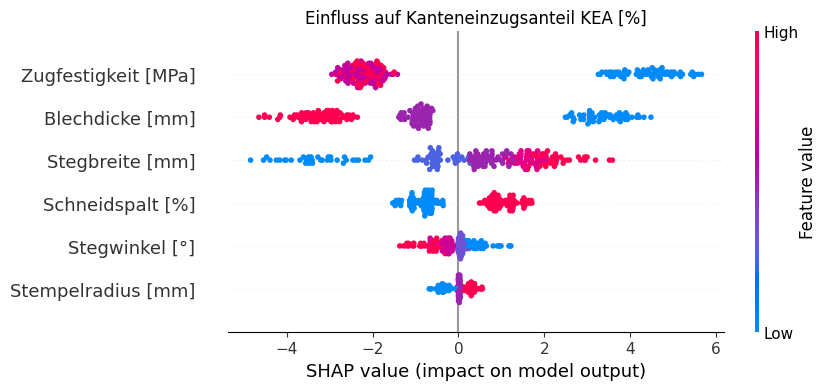

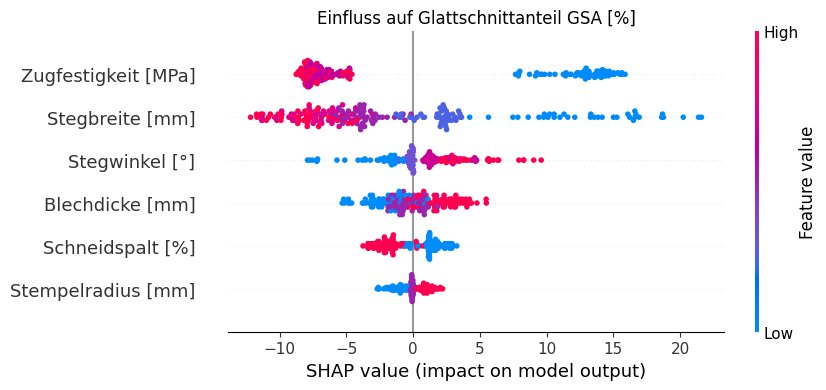

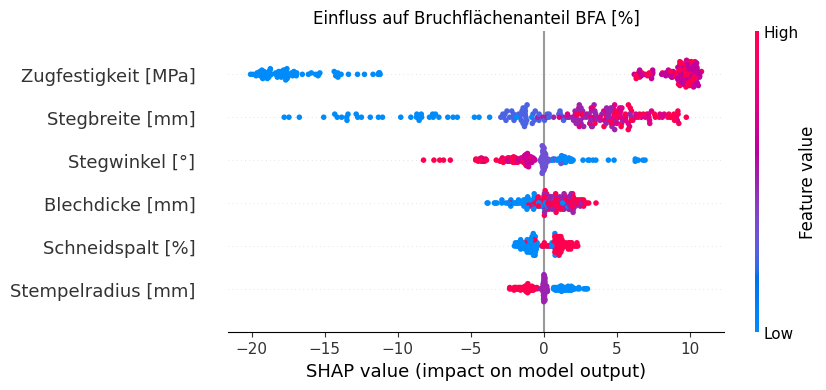

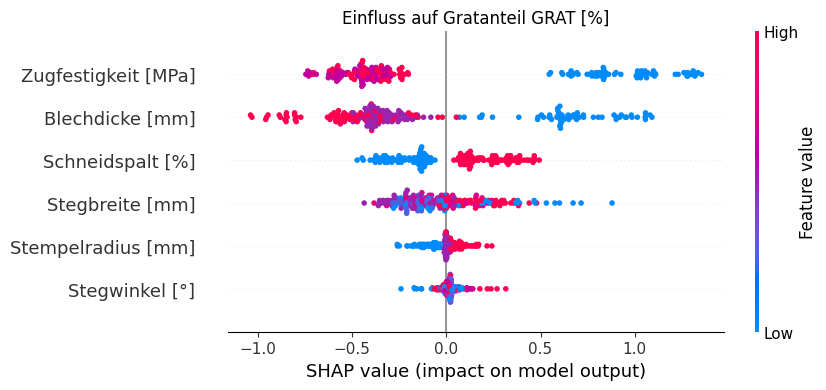

In [6]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Falls X_train und X_test DataFrames sind, in NumPy-Arrays umwandeln
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Namen der Eingangsmerkmale
FEATURE_NAMES = [
    "Zugfestigkeit [MPa]",
    "Blechdicke [mm]",
    "Schneidspalt [%]",
    "Stegbreite [mm]",
    "Stegwinkel [°]",
    "Stempelradius [mm]"
]

# Namen der Ausgabewerte
Ausgabe_NAMES = [
    "Kanteneinzugsanteil KEA [%]",
    "Glattschnittanteil GSA [%]",
    "Bruchflächenanteil BFA [%]",
    "Gratanteil GRAT [%]"
]

# SHAP-Explainer für das Modell erstellen
explainer = shap.Explainer(model, X_train_np)

# Für jede Zielgröße die SHAP-Werte berechnen und visualisieren
for i in range(0, 4):
    # SHAP-Werte für Testdaten berechnen
    shap_values = explainer(X_test_np)
    shap_values.feature_names = FEATURE_NAMES
    plt.title("Einfluss auf " + Ausgabe_NAMES[i])
    shap.plots.beeswarm(shap_values[:, :, i])
